## **Introduction**
In this notebook, we will build and train a neural network for classifying blood cells using ResNet, a deep residual network architecture.

This project demonstrates the application of deep learning to medical imaging and classification tasks.


## 🚀 Setting Up the Environment: Installing Packages and Connecting to Google Drive


In [1]:
!pip install tensorflow==2.17.0 keras==3.4.1 tensorflow-decision-forests==1.10.0 tensorflow-text==2.17.0 tf-keras==2.17.0 keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 96.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


In [2]:
from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras import layers as layers
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import LambdaCallback

import keras
import keras_cv
import numpy as np
import tensorflow as tf

In [3]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1/

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


In [4]:
random_seed = 42

np.random.seed(random_seed)
tf.random.set_seed(random_seed);

## ⏳ Load the Data

In [5]:
PATH_TRAINING_SET = "Resnet/training_set.npz"
assert PATH_TRAINING_SET != "", "PATH_TRAINING_SET cannot be empty."

In [6]:
data = np.load(PATH_TRAINING_SET)
X = data['images']
y = data['labels']

## 🧹 Data Preprocessing: Preparing the Dataset for Training


### Removing duplicates (outliers)

In [7]:
import hashlib

def image_hash(image):
    image_bytes = image.tobytes()
    return hashlib.sha256(image_bytes).hexdigest()

def remove_duplicates(x_train, y_train):
  unique_images = []
  unique_labels = []
  duplicate_positions = set()

  seen_hashes = {}

  for i in range(len(X)):
      img_hash = image_hash(X[i])
      if img_hash not in seen_hashes:
          if i not in duplicate_positions:
              unique_images.append(X[i])
              unique_labels.append(y[i])
          seen_hashes[img_hash] = i
      else:
          duplicate_positions.add(seen_hashes[img_hash])
          duplicate_positions.add(i)

  X = [X[i] for i in range(len(X)) if i not in duplicate_positions]
  y = [y[i] for i in range(len(y)) if i not in duplicate_positions]

  X = np.array(X)
  y = np.array(y)

  return X, y

  X, y = remove_duplicates(X, y)

### Balancing the classes

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
])

# Extract unique classes and their counts
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Original distribution:", class_counts)

# Maximum number of samples for a class
max_samples = max(class_counts.values())

def balance_with_augmented(X, y):
# New balanced dataset
  X_balanced = []
  y_balanced = []

  # Oversampling for each class
  for cls in class_counts:
      # Filter samples for the current class
      X_class = X[np.where(y == cls)[0]]
      y_class = y[y == cls]

      # Calculate the number of samples to add
      samples_to_add = max_samples - len(X_class)

      if samples_to_add > 0:
          # Augment the samples to add
          augmented_images = []
          for _ in range(samples_to_add):
              augmented_image = data_augmentation(X_class[np.random.randint(len(X_class))][np.newaxis, ...])
              augmented_images.append(augmented_image.numpy()[0])

          # Add the original and augmented samples to the balanced dataset
          X_balanced.append(np.concatenate([X_class, np.array(augmented_images)]))
          y_balanced.append(np.concatenate([y_class, np.full(samples_to_add, cls)]))
      else:
          # Add the original samples to the balanced dataset (if no oversampling is needed)
          X_balanced.append(X_class)
          y_balanced.append(y_class)

  # Concatenate the balanced dataset
  X = np.concatenate(X_balanced)
  y = np.concatenate(y_balanced)

  return X, y

X, y = balance_with_augmented(X, y)

# Check the new distribution
unique_balanced, counts_balanced = np.unique(y, return_counts=True)
class_counts_balanced = dict(zip(unique_balanced, counts_balanced))
print("Balanced distribution of classes:", class_counts_balanced)

Original distribution: {0: 1052, 1: 2381, 2: 1285, 3: 2226, 4: 1049, 5: 1393, 6: 2530, 7: 1843}
Balanced distribution of classes: {0: 2530, 1: 2530, 2: 2530, 3: 2530, 4: 2530, 5: 2530, 6: 2530, 7: 2530}


In [9]:
# Converts the target classes into one-hot-encoding
y = tf.keras.utils.to_categorical(y, num_classes=8)

## Splitting in training, validation e test set

In [10]:
# Split train in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [11]:
# Split train in training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

## 🔄 Data Augmentation: Enhancing the Dataset


In [12]:
# Function to randomly extract a certain number of pictures and corresponding labels
def sample_random_images(dataset, sample_size=5):
    random_samples = dataset.shuffle(buffer_size=1000).take(sample_size)
    images = []
    labels = []
    for image, label in random_samples:
        images.append(image.numpy())
        labels.append(label.numpy())
    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

X_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [13]:
# Function to perform augmentations before the training
def augment(images, labels):
    augmenter = keras_cv.layers.Augmenter(
        layers = [
            keras_cv.layers.RandomFlip(
                mode="horizontal_and_vertical"
            ),
            keras_cv.layers.RandomRotation(
                factor=0.2,
                fill_mode='nearest'
            ),
            keras_cv.layers.MixUp(
                alpha=0.5,
            ),
            keras_cv.layers.CutMix(
                alpha=0.5
            ),

            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),

        ]
    )

    inputs = {"images": images, "labels": labels}
    output = augmenter(inputs)
    return output["images"], output["labels"]

In [14]:
# We randomly sample 4000 pairs and apply the augmentation above
random_X, random_y = sample_random_images(X_train_dataset, 4000)
aug_images, aug_labels = augment(random_X, random_y)

X_train = tf.concat([X_train, aug_images], axis=0)
y_train = tf.concat([y_train, aug_labels], axis=0)

In [15]:
def apply_augmentation(image, is_randaugment):
    if is_randaugment:
        return apply_randaugment(image)
    else:
        return apply_augmix(image)

def apply_augmix(image):
    return augmix(image)

def apply_randaugment(image):
    return randaugmenter(image)

randaugmenter = tf.keras.Sequential(
    [
        keras_cv.layers.RandAugment([0, 255], 3, 0.4),
    ]
)

augmix = tf.keras.Sequential(
    [
        keras_cv.layers.AugMix([0, 255]),
    ]
)

batch_size = 256
half_size = len(X_train) // 2

# We apply the RandAugment augmentation to the first half of the dataset
dataset_randaugment = tf.data.Dataset.from_tensor_slices(X_train[:half_size])
dataset_randaugment = dataset_randaugment.map(lambda x: apply_augmentation(x, is_randaugment=True), num_parallel_calls=tf.data.AUTOTUNE)

# We apply the AugMix augmentation to the second half of the dataset
dataset_augmix = tf.data.Dataset.from_tensor_slices(X_train[half_size:])
dataset_augmix = dataset_augmix.map(lambda x: apply_augmentation(x, is_randaugment=False), num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset_randaugment.concatenate(dataset_augmix)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

X_train = tf.concat([batch for batch in dataset], axis=0)

del X_train_dataset

### Plotting some augmented images

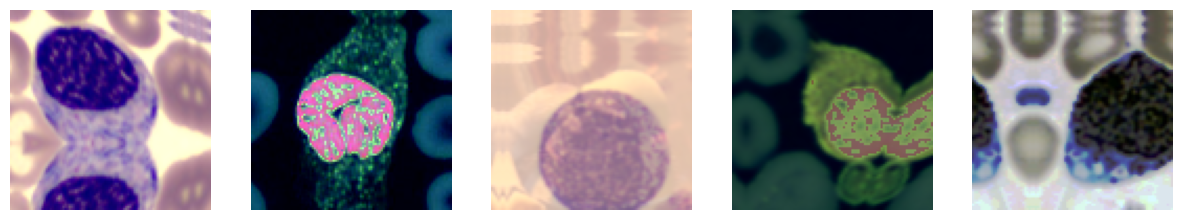

In [16]:
import matplotlib.pyplot as plt

num_images = 5
plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)  # Create a 1-row subplot for 10 images
    plt.imshow(X_train[i] / 255.0)    # Normalize and plot each image
    plt.axis('off')                  # Turn off axis labels for clarity

plt.show()

## 🏗️ Defining the Model: Building the MyModel Class


In [17]:
class MyModel:
    def __init__(self):
        """
        Initializes the internal state of the model.
        """
        self.strategy = tf.distribute.MirroredStrategy()
        self.neural_network = self.create_model()

    def get_augmentation_layer(self):
      """
      Defines the augmentations layers that will be used in the model
      """
      return tf.keras.Sequential([
          # Random rotation
          keras.layers.RandomRotation(0.5, fill_mode='reflect'),

          # Random zoom in height
          keras.layers.RandomZoom(height_factor=(-0.2, 0.7), fill_mode='nearest'),

          # Other types of augmentations
          keras.layers.RandomZoom(height_factor=(0.0, 0.0), width_factor=(-0.3, 0.3), fill_mode='nearest'),
          keras.layers.RandomFlip(mode="horizontal"),
          keras.layers.RandomFlip(mode="vertical"),
          keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),

          keras.layers.RandomBrightness(0.3),
          #keras_cv.layers.RandomHue(0.3, [0,255]),
          keras_cv.layers.RandomContrast([0, 255], 0.3),
          keras_cv.layers.RandomGaussianBlur(2, 2),
          #keras_cv.layers.RandomCutout(0.3, 0.3,"gaussian_noise"),

          # Adding Gaussian noise
          keras.layers.GaussianNoise(0.07)
      ])

    def create_model(self):
        """
        Creates and returns a model
        """
        # Define data augmentation layers
        data_augmentation = self.get_augmentation_layer()

        with self.strategy.scope():

            # Use a pre-trained network
            self.model_name_pretrained = 'convnext_base'
            model_pretrained = tfk.applications.ConvNeXtBase(
                input_shape=(96, 96, 3),
                include_top=False,
                weights='imagenet',
                pooling=None
            )

            print("number of layers:")
            print(len(model_pretrained.layers))

            # Build the model
            inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')
            x = data_augmentation(inputs)
            x = model_pretrained(x)

            # Batch Normalization after the pre-trained model
            x = tfk.layers.BatchNormalization()(x)

            # Squeeze-and-Excitation (SE Block)
            se = tfk.layers.GlobalAveragePooling2D()(x)  # Reduces to (batch_size, channels)
            se = tfk.layers.Dense(se.shape[-1] // 16, activation='relu')(se)  # Compress
            se = tfk.layers.Dense(se.shape[-1] * 16, activation='sigmoid')(se)  # Expand
            x = tfk.layers.Multiply()([x, tfk.layers.Reshape((1, 1, -1))(se)])  # Scale channels

            # Global Pooling (to reduce dimensionality)
            x = tfk.layers.GlobalAveragePooling2D()(x)

            # Fully Connected layers with Batch Normalization and Leaky ReLU
            x = tfk.layers.Dense(512)(x)
            x = tfk.layers.BatchNormalization()(x)
            x = tfk.layers.LeakyReLU(alpha=0.1)(x)
            x = tfk.layers.Dropout(0.3)(x)

            x = tfk.layers.Dense(256)(x)
            x = tfk.layers.BatchNormalization()(x)
            x = tfk.layers.LeakyReLU(alpha=0.1)(x)
            x = tfk.layers.Dropout(0.3)(x)

            outputs = tfk.layers.Dense(8, activation='softmax', name='output_layer')(x)

            model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

            return model

    def train_transfer_learning(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
        """
        Pre-trains the model freezing the pre-trained layers
        """

        with self.strategy.scope():  # Ensure training happens inside strategy scope

            self.neural_network.get_layer(self.model_name_pretrained).trainable = False

            # Freeze all layers of the pre-trained network
            for i, layer in enumerate(self.neural_network.get_layer(self.model_name_pretrained).layers):
                layer.trainable = False

            # Compile the model
            self.neural_network.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(learning_rate=1e-3),
                metrics=['accuracy']
            )

            # Callbacks
            # Callback to save a checkpoint of the model every 10 epochs
            save_every_10 = LambdaCallback(
                on_epoch_end=lambda epoch, logs:
                self.neural_network.save(f'model_epoch_{epoch + 1}.keras') if (epoch + 1) % 10 == 0 else None
            )

            # Callback for early stopping
            early_stopping = tfk.callbacks.EarlyStopping(
                monitor='val_accuracy',
                mode='max',
                patience=10,
                restore_best_weights=True
            )

            # Train the model
            history = self.neural_network.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[save_every_10, early_stopping]
            )

            return history

    def train_fine_tuning(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32, fine_tune_from=50):
        """
        Unlocks selected layers and trains the model.
        """
        with self.strategy.scope():  # Ensure training happens inside strategy scope

            self.neural_network.get_layer(self.model_name_pretrained).trainable = True

            # Unlock convolutional layers from the `fine_tune_from` layer onward
            for i, layer in enumerate(self.neural_network.get_layer(self.model_name_pretrained).layers):
                layer.trainable = False
                if i > fine_tune_from:
                    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
                        print(True)
                        layer.trainable = True

            # Compile the model with a lower learning rate
            self.neural_network.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(learning_rate=1e-4),
                metrics=['accuracy']
            )

            # Callbacks
            # Callback to save a checkpoint of the model every 10 epochs
            save_every_10 = LambdaCallback(
                on_epoch_end=lambda epoch, logs:
                self.neural_network.save(f'model_epoch_{epoch + 1}.keras') if (epoch + 1) % 10 == 0 else None
            )

            # Callback for early stopping
            early_stopping = tfk.callbacks.EarlyStopping(
                monitor='val_accuracy',
                mode='max',
                patience=10,
                restore_best_weights=True
            )

            # Train the model
            history = self.neural_network.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[save_every_10, early_stopping]
            )

            return history


    def plot_history(self, history):
        # Extract the history data
        history_data = history.history

        # Extract the number of epochs
        epochs = range(1, len(history_data["loss"]) + 1)

        # Plot loss and validation loss
        plt.figure(figsize=(14, 5))

        # Subplot 1: Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history_data["loss"], label="Training Loss", marker="o")
        plt.plot(epochs, history_data["val_loss"], label="Validation Loss", marker="o")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        # Subplot 2: Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history_data["accuracy"], label="Training Accuracy", marker="o")
        plt.plot(epochs, history_data["val_accuracy"], label="Validation Accuracy", marker="o")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        # Show the plots
        plt.tight_layout()
        plt.show()


    def test(self, X_test, y_test):
        """
        Evaluates the model on test data X_test and labels y_test.
        """
        test_loss, test_acc = self.neural_network.evaluate(X_test, y_test)
        print(f'Test accuracy: {test_acc}')

    def load(self, path):
        """
        Loads a model from the specified path.
        """
        with self.strategy.scope():
            self.neural_network = tfk.models.load_model(path)
            self.neural_network.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(),
                metrics=['accuracy']
            )

    def save(self):
        """
        Saves the model
        """
        self.neural_network.save('/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/weights.keras')

    def predict(self, X):
        """
        Predicts labels for the input X.
        """
        preds = self.neural_network.predict(X)
        return preds


## 🛠️ Train and Save the Model

In [18]:
model = MyModel()

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step
number of layers:
259


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Traing is performed

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.3348 - loss: 1.9230 - val_accuracy: 0.5761 - val_loss: 1.4151
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.5163 - loss: 1.3577 - val_accuracy: 0.7569 - val_loss: 0.7425
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.5584 - loss: 1.2541 - val_accuracy: 0.7683 - val_loss: 0.6730
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.5733 - loss: 1.1968 - val_accuracy: 0.7875 - val_loss: 0.6091
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.5836 - loss: 1.1809 - val_accuracy: 0.7920 - val_loss: 0.6337
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.5972 - loss: 1.1490 - val_accuracy: 0.8083 - val_loss: 0.5700
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.6048 - loss: 1.1340 - val_accuracy: 0.7964 - val_loss: 0.5390
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.6087 - loss: 1.1116 - val_accuracy: 0.7831 - v

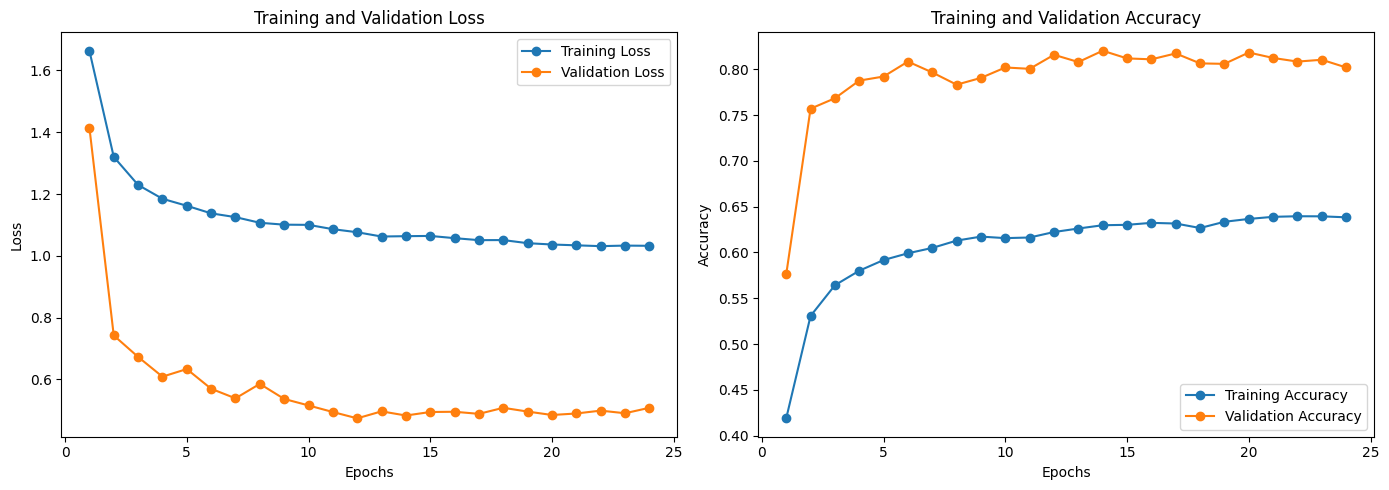

In [19]:
history = model.train_transfer_learning(X_train, y_train, X_test, y_test, 50, 512)
#history = model.train_transfer_learning(X_train, y_train, X_test, y_test, 1, 512)
model.plot_history(history)

Fine-tuning is performed

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 329s 8s/step - accuracy: 0.6318 - loss: 1.0535 - val_accuracy: 0.8231 - val_loss: 0.4798
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 308s 8s/step - accuracy: 0.6524 - loss: 1.0031 - val_accuracy: 0.8305 - val_loss: 0.4630
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 311s 8s/step - accuracy: 0.6604 - loss: 0.9812 - val_accuracy: 0.8286 - val_loss: 0.4556
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 311s 8s/step - accuracy: 0.6664 - loss: 0.9606 - val_accuracy: 0.8379 - val_loss: 0.4397
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 310s 8s/step - accuracy: 0.6782 - loss: 0.9415 - val_accuracy: 0.8379 - val_loss: 0.4334
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 310s 8s/step - accuracy: 0.6814 - loss: 0.9336 - val_accuracy: 0.8488 - val_loss: 0.4130
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 311s 8s/step - accuracy: 0.6837 - loss: 0.9290 - val_accuracy: 0.8503 - val_loss: 0.4115
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━

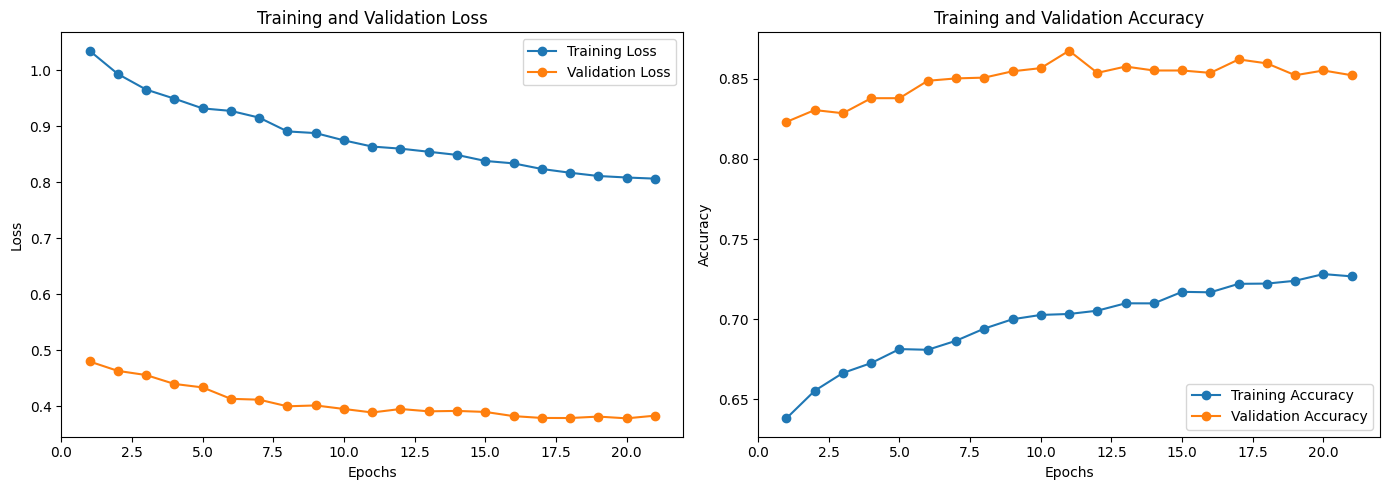

In [20]:
history = model.train_fine_tuning(X_train, y_train, X_test, y_test, 50, 512, 150)
#history = model.train_fine_tuning(X_train, y_train, X_test, y_test, 1, 512, 150)
model.plot_history(history)

## 📊 Model Evaluation: Assessing Performance and Accuracy


In [21]:
model.test(X_test, y_test)

64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - accuracy: 0.8677 - loss: 0.3974
Test accuracy: 0.8586956262588501


Evaluating with augmented test set

In [22]:
randaugmenter = tf.keras.Sequential([
    keras_cv.layers.RandAugment([0, 255], 3, 0.4)
])

augmented_test = randaugmenter(X_test)
augmented_test = model.get_augmentation_layer()(augmented_test)

In [23]:
model.test(augmented_test, y_test)

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - accuracy: 0.7159 - loss: 0.7792
Test accuracy: 0.7168972492218018


### Plotting confusion matrix

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score

def plot_confusion_matrix(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


def evaluate_model(y_true, y_pred):
    # Convert one-hot encoding to class labels for precision, recall, and accuracy
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
    else:
        y_true_labels = y_true
        y_pred_labels = y_pred

    # Compute metrics
    precision = precision_score(y_true_labels, y_pred_labels, average="weighted")
    recall = recall_score(y_true_labels, y_pred_labels, average="weighted")
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    roc_auc = roc_auc_score(y_true, y_pred, multi_class="ovr")
    f1 = f1_score(y_true_labels, y_pred_labels, average="weighted")

    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step
Precision: 0.8814
Recall: 0.8582
Accuracy: 0.8582
ROC AUC: 0.9878
F1 Score: 0.8623


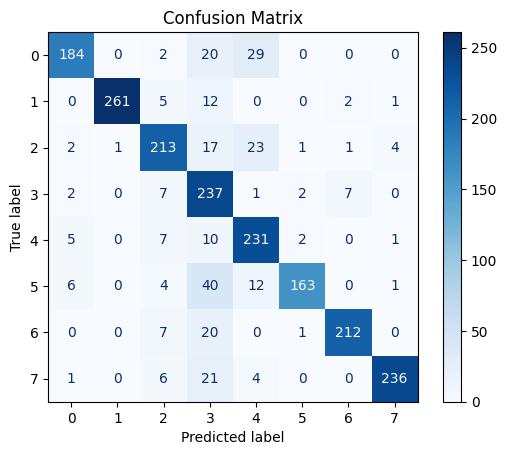

In [25]:
preds = model.predict(X_test)
evaluate_model(y_test, preds)

Evaluating with augmented test set

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step
Precision: 0.7370
Recall: 0.7169
Accuracy: 0.7169
ROC AUC: 0.9519
F1 Score: 0.7233


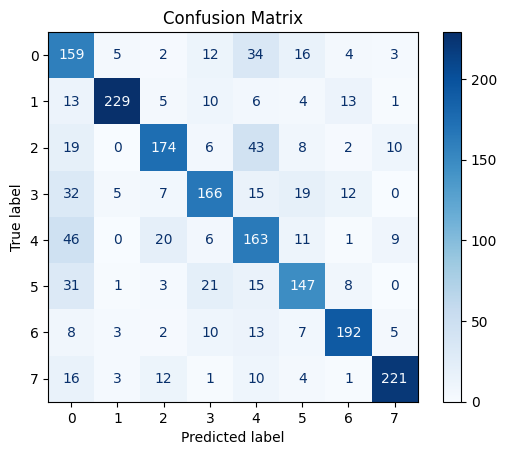

In [26]:
preds_augmented = model.predict(augmented_test)
evaluate_model(y_test, preds_augmented)

## 💾 Saving the Model

In [27]:
model.neural_network.save('weights.keras')

In [28]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [29]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 48%)
  adding: weights.keras (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>